In [1]:
! export PYTHONPATH="$PYTHONPATH:$HOME/generic_implementation/POISEVAE"

In [2]:
import glob 

import numpy as np
import torch
import torch.nn as nn
from torch.nn import functional as F  # activation function
import torch.optim as optim
from tqdm import tqdm
import matplotlib.pyplot as plt

from joint_dataset import CUB
from POISEVAE import POISEVAE # Remember to do export PYTHONPATH ...
from POISEVAE import util

plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42
plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['font.size'] = 20
plt.rcParams['font.weight'] = 'normal'
plt.rcParams['mathtext.fontset'] = 'cm'
plt.rcParams['text.usetex'] = False

In [3]:
DATA_PATH = 'CUB/'

In [4]:
class EncImg(nn.Module):
    def __init__(self, latent_dim, input_dim=2048):
        super(EncImg, self).__init__()
        self.input_dim = input_dim
        self.latent_dim = latent_dim

        n = (input_dim, 1024, 512, 256)
        li = []
        for i in range(len(n)-1):
            li += [nn.Linear(n[i], n[i+1]), nn.ELU(inplace=True)]
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Linear(256, latent_dim)
        self.enc_var = nn.Linear(256, latent_dim)
        
    def forward(self, x):
        x = self.enc(x)
        mu = self.enc_mu(x)
        log_var = self.enc_var(x)
        return mu, log_var

class DecImg(nn.Module):
    def __init__(self, latent_dim, output_dim=2048):
        super(DecImg, self).__init__()  
        self.latent_dim = latent_dim
        self.output_dim = output_dim
        
        n = (output_dim, 1024, 512, 256)
        li = [nn.Linear(latent_dim, 256)]
        for i in range(len(n)-1, 0, -1):
            li += [nn.ELU(inplace=True), nn.Linear(n[i], n[i-1])]
        self.dec = nn.Sequential(*li)
        
    def forward(self, z):
        return self.dec(z)

In [5]:
class EncTxt(nn.Module):
    def __init__(self, vocab_size, latent_dim, emb_dim=128):
        super(EncTxt, self).__init__()
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        
        # 0 is for the excluded words and does not contribute to gradient
        self.emb = nn.Embedding(vocab_size, emb_dim, padding_idx=0)

        n_channels = (1, 32, 64, 128, 256, 512)
        kernels = (4, 4, 4, (1, 4), (1, 4))
        strides = (2, 2, 2, (1, 2), (1, 2))
        paddings = (1, 1, 1, (0, 1), (0, 1))
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li += [nn.Conv2d(n_channels[i-1], n, kernel_size=k, stride=s, padding=p), 
                   nn.BatchNorm2d(n), nn.ReLU(inplace=True)]
            
        self.enc = nn.Sequential(*li)
        self.enc_mu = nn.Conv2d(512, latent_dim, kernel_size=4, stride=1, padding=0)
        self.enc_var = nn.Conv2d(512, latent_dim, kernel_size=4, stride=1, padding=0)
        
    def forward(self, x):
        x = self.emb(x.long()).unsqueeze(1) # add channel dim
        x = self.enc(x)
        mu = self.enc_mu(x).squeeze()
        log_var = self.enc_var(x).squeeze()
        return mu, log_var

class DecTxt(nn.Module):
    def __init__(self, vocab_size, latent_dim, emb_dim=128, txt_len=32):
        super(DecTxt, self).__init__()
        self.vocab_size = vocab_size
        self.latent_dim = latent_dim
        self.emb_dim = emb_dim
        self.txt_len = txt_len
        
        n_channels = (1, 32, 64, 128, 256, 512, latent_dim)
        kernels = (4, 4, 4, (1, 4), (1, 4), 4)
        strides = (2, 2, 2, (1, 2), (1, 2), 1)
        paddings = (1, 1, 1, (0, 1), (0, 1), 0)
        li = []
        for i, (n, k, s, p) in enumerate(zip(n_channels[1:], kernels, strides, paddings), 1):
            li = [nn.ConvTranspose2d(n, n_channels[i-1], kernel_size=k, stride=s, padding=p), 
                  nn.BatchNorm2d(n_channels[i-1]), nn.ReLU(inplace=True)] + li
            
        # No batchnorm at the first and last block
        del li[-2]
        del li[1]
        self.dec = nn.Sequential(*li)
        self.anti_emb = nn.Linear(emb_dim, vocab_size)
        
    def forward(self, z, argmax=False):
        z = self.dec(z)
        z = self.anti_emb(z.view(-1, self.emb_dim))
        z = z.view(-1, self.txt_len, self.vocab_size) # batch x txt len x vocab size
        if argmax:
            z = z.argmax(-1).float()
        return z

In [6]:
tx = lambda data: torch.Tensor(data)

In [7]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [8]:
CUB_train = CUB(DATA_PATH, DATA_PATH, 'train', device, tx, return_idx=False)
CUB_test = CUB(DATA_PATH, DATA_PATH, 'test', device, tx, return_idx=True)

In [9]:
vocab_size, txt_len = CUB_train.CUBtxt.vocab_size, CUB_train.CUBtxt.max_sequence_length
vocab_size, txt_len

(1590, 32)

In [10]:
batch_size = 128
train_loader = torch.utils.data.DataLoader(CUB_train, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(CUB_test, batch_size=batch_size, shuffle=True)
len(train_loader), len(test_loader)

(692, 230)

In [11]:
enc_img = EncImg(128).to(device)
dec_img = DecImg(128).to(device)
enc_txt = EncTxt(vocab_size, 128).to(device)
dec_txt = DecTxt(vocab_size, 128).to(device)

def CELoss(input, target):
    batch_size = target.shape[0]
    input, target = input.view(-1, vocab_size), target.view(-1).to(torch.long)
    loss = nn.functional.cross_entropy(input, target, reduction='sum') #/ batch_size
    return loss * 10
    
def MSELoss(input, target):
    loss = nn.functional.mse_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
def MAELoss(input, target):
    loss = nn.functional.l1_loss(input, target, reduction='sum') #/ batch_size
    return loss
    
vae = POISEVAE([enc_img, enc_txt], [dec_img, dec_txt], [MAELoss, CELoss], 
               latent_dims=[128, (128, 1, 1)]).to(device)

In [12]:
# for i in vae.named_parameters():
#     print(i[0])

In [13]:
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

In [14]:
PATH = 'CUB_train_results/'

In [15]:
epoch = 0
# try:
#     vae, optimizer, epoch = util.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])
# except:
#     pass

In [ ]:
train_loss = []
test_loss = []
epochs = 50 + epoch
for epoch in range(epoch, epochs):
    print(f"Epoch {epoch+1} of {epochs}")
    train_epoch_losses = util.train(vae, train_loader, optimizer, epoch)
    train_loss.append(train_epoch_losses)
    ret = util.test(vae, test_loader, epoch, return_latents=True)
    test_epoch_losses, latent_info = ret[:4], ret[-1]
    test_loss.append(test_epoch_losses)
    print(f"Train Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % train_epoch_losses)
    print(f"Test Loss: %.4f\n\tRec: %.4f, %.4f\n\tKLD Loss %.4f" % test_epoch_losses)
    if (epoch+1) % 10 == 0 and epoch > 0:
        util.save_checkpoint(vae, optimizer, PATH + 'training_%d.pt' % (epoch+1), epoch+1)
train_loss = np.array(train_loss).T
test_loss = np.array(test_loss).T

Epoch 1 of 50
Train Loss: 967.1670
	Rec: 456.9264, 520.6595
	KLD Loss -10.4189
Test Loss: 832.6985
	Rec: 429.8686, 414.3384
	KLD Loss -11.5085
Epoch 2 of 50
Train Loss: 778.1060
	Rec: 409.5569, 376.9351
	KLD Loss -8.3860
Test Loss: 735.7122
	Rec: 399.6832, 342.3702
	KLD Loss -6.3412
Epoch 3 of 50
Train Loss: 693.0311
	Rec: 384.5006, 313.6141
	KLD Loss -5.0837
Test Loss: 670.3069
	Rec: 382.3258, 291.8292
	KLD Loss -3.8481
Epoch 4 of 50
Train Loss: 637.0734
	Rec: 369.8317, 270.6294
	KLD Loss -3.3877
Test Loss: 630.5887
	Rec: 372.0291, 261.4704
	KLD Loss -2.9107
Epoch 5 of 50
Train Loss: 598.4319
	Rec: 359.7926, 240.9544
	KLD Loss -2.3151
Test Loss: 597.9748
	Rec: 363.6554, 236.8637
	KLD Loss -2.5443
Epoch 6 of 50
Train Loss: 569.9871
	Rec: 353.0890, 218.5805
	KLD Loss -1.6824
Test Loss: 580.3584
	Rec: 359.2791, 222.6620
	KLD Loss -1.5827
Epoch 7 of 50
Train Loss: 549.1177
	Rec: 348.4976, 201.4927
	KLD Loss -0.8725
Test Loss: 560.3266
	Rec: 356.4447, 206.0394
	KLD Loss -2.1575
Epoch 8 of 

In [ ]:
util.save_latent_info(latent_info, PATH)

In [ ]:
fig, ax = plt.subplots(ncols=2, sharex='all', sharey='all', figsize=(9, 4))

for i, label in enumerate(('Total', 'Rec1', 'Rec2', 'KLD')):
    ax[0].plot(train_loss[i], label=label)
    ax[1].plot(test_loss[i], label=label)
ax[0].set_title('Train')
ax[1].set_title('Validation')
fig.legend(*ax[0].get_legend_handles_labels(), fontsize='small')
fig.tight_layout()

## Results

In [16]:
def pdist(sample_1, sample_2, eps=1e-8):
    """Compute the matrix of all squared pairwise distances. Code
    adapted from the torch-two-sample library (added batching).
    You can find the original implementation of this function here:
    https://github.com/josipd/torch-two-sample/blob/master/torch_two_sample/util.py
    Arguments
    ---------
    sample_1 : torch.Tensor or Variable
        The first sample, should be of shape ``(batch_size, n_1, d)``.
    sample_2 : torch.Tensor or Variable
        The second sample, should be of shape ``(batch_size, n_2, d)``.
    norm : float
        The l_p norm to be used.
    batched : bool
        whether data is batched
    Returns
    -------
    torch.Tensor or Variable
        Matrix of shape (batch_size, n_1, n_2). The [i, j]-th entry is equal to
        ``|| sample_1[i, :] - sample_2[j, :] ||_p``."""
    if len(sample_1.shape) == 2:
        sample_1, sample_2 = sample_1.unsqueeze(0), sample_2.unsqueeze(0)
    B, n_1, n_2 = sample_1.size(0), sample_1.size(1), sample_2.size(1)
    norms_1 = torch.sum(sample_1 ** 2, dim=-1, keepdim=True)
    norms_2 = torch.sum(sample_2 ** 2, dim=-1, keepdim=True)
    norms = (norms_1.expand(B, n_1, n_2)
             + norms_2.transpose(1, 2).expand(B, n_1, n_2))
    distances_squared = norms - 2 * sample_1.matmul(sample_2.transpose(1, 2))
    return torch.sqrt(eps + torch.abs(distances_squared)).squeeze()  # batch x K x latent


def NN_lookup(emb_h, emb):
    dist = pdist(emb.to(emb_h.device), emb_h)
    return dist, dist.argmin(dim=0)

In [17]:
vae, optimizer, epoch = util.load_checkpoint(vae, optimizer, sorted(glob.glob(PATH + 'train*.pt'))[-1])

In [18]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        results = vae([img.to(device), txt.to(device)])
        dist, idx_h = NN_lookup(results['x_rec'][0], img)
        # dist, idx_h = NN_lookup(results['x_rec'][0], img)
        imgs_h = [CUB_test.CUBimg.dataset[int(idx[j]) // 10][0] for j in idx_h]
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10][0] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

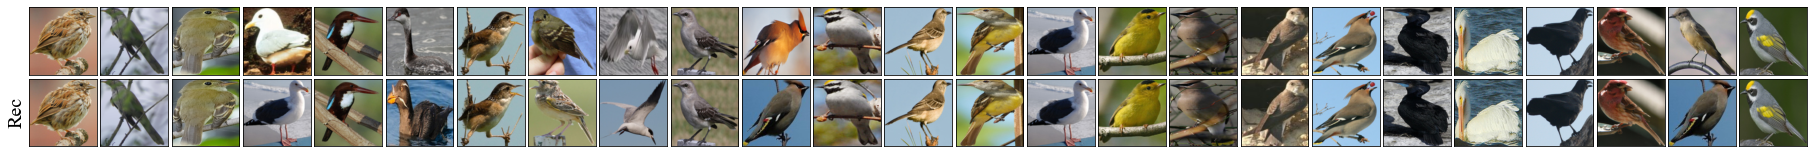

In [19]:
ncols = min(len(imgs_h), 25)
fig, ax = plt.subplots(nrows=2, ncols=ncols, figsize=(25, 2))
for i, aux in enumerate(zip(imgs, imgs_h)):
    if i >= ncols:
        break
    for j, im in enumerate(aux):
        ax[j, i].imshow(im.permute(1, 2, 0))
        ax[j, i].set_xticks([])
        ax[j, i].set_yticks([])
ax[1, 0].set_ylabel('Rec', fontsize=20)
fig.tight_layout(pad=0)

In [20]:
sents_h = []
sents_emb = results['x_rec'][1].argmax(-1)
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

for i, sent_h in enumerate(sents_h):
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    print('     ', ' '.join(sent))
    print('Rec: ', sent_h)

      a brown and black bird with a very round shape and a short , sharp beak .
Rec:  a white and brown bird with a medium round disposition and a small , pointed beak .
      this mostly gray feathered bird has a long beak and tail .
Rec:  this vibrant colored colored bird has a long beak and beak .
      this tiny bird has a reddish green back and head , with a yellow eye ring , and brown inner and outer rectrices .
Rec:  this colorful bird has a light green head and head , with a yellow crown , belly and brown wings and and secondaries .
      this white bird has light gray wing feathers and a bright orange beak and feet .
Rec:  this white bird has gray gray wing feathers and a bright orange beak and orange .
      this bird has a brown body with a white patch on its breast and a really long thick bill .
Rec:  this bird has a brown body with a white stripe on its wings and a long , short bill .
      this bird has wings that are brown and has red eyes .
Rec:  this bird has wings tha

#### Truth

In [ ]:
with torch.no_grad():
    for i, (img, txt, idx) in enumerate(test_loader):
        imgs = [CUB_test.CUBimg.dataset[int(j) // 10] for j in idx]
        txts = [CUB_test.CUBtxt.data[str(int(j))] for j in idx]
        break

In [ ]:
sents_h = []
sents_emb = txt[0]
for sent_emb in sents_emb:
    sent_h = []
    for j in sent_emb:
        char = CUB_test.CUBtxt.i2w[str(int(j.item()))]
        if char == '<eos>':
            break
        sent_h.append(char)
    sents_h.append(' '.join(sent_h))

for i, sent_h in enumerate(sents_h):
    print(sent_h)
    sent = []
    for char in txts[i]['tok']:
        if char == '<eos>':
            break
        sent.append(char)
    print(' '.join(sent))

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=len(imgs), figsize=(40, 2))
for i, img in enumerate(imgs):
    ax[i].imshow(img[0].permute(1, 2, 0))
    print(img[1])
    ax[i].set_axis_off()
fig.tight_layout(pad=0)